In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
#
from scipy.stats import qmc # upgrade scipy for LHS !pip install scipy --upgrade

In [2]:
tf.keras.backend.set_floatx("float64")

In [16]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1)

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
t_d = np.append(temp, t_d, axis=0)
# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5)
temp1 = -1 * np.ones([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

Text(0.5, 1.0, 'Data points (BCs & IC)')

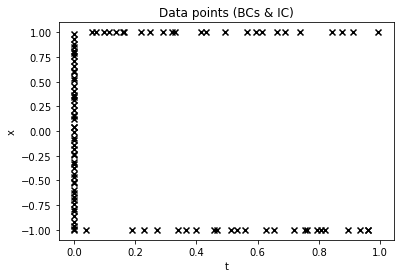

In [31]:
# view randomly sampled boundary and initial points
plt.scatter(t_d, x_d, marker="x", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [18]:
# output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape)

# for initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

# all boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0

In [19]:
# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
# set x values between -1. and +1.
data[:, 1] = 2*(data[:, 1]-0.5)

# change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

In [20]:
# convert all data and collocation points to tf.Tensor
x_d, t_d, y_d, x_c, t_c = map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

In [21]:
### model design
#
neuron_per_layer = 20
# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,))

# hidden layer
# also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)
hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden5)
hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden6)
hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden7)

# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden8)

model = tf.keras.Model(input_layer, output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_11 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_12 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_13 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_14 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_15 (Dense)             (None, 20)                420 

In [22]:
# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(t, x):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model(tf.concat([t, x], axis=1)) # note the axis ; `column`
    return u

In [23]:
# the physics informed loss function
# IMPORTANT: this loss function is used for collocation points
@tf.function
def f(t, x):
    u0 = u(t, x)
    u_t = tf.gradients(u0, t)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    F = u_t + u0*u_x - (0.01/np.pi)*u_xx
    return tf.reduce_mean(tf.square(F))

In [24]:
# MSE loss function
# IMPORTANT: this loss function is used for data points
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

In [25]:
import time

In [26]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 2000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u(t_d, x_d)
        # physics-informed loss for collocation points
        L1 = f(t_c, x_c)
        # MSE loss for data points
        L2 = mse(y_d, y_)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"{epoch:4} {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

   0 0.214
  10 0.192
  20 0.183
  30 0.172
  40 0.158
  50 0.147
  60 0.140
  70 0.131
  80 0.122
  90 0.115
 100 0.109
 110 0.104
 120 0.100
 130 0.097
 140 0.094
 150 0.092
 160 0.090
 170 0.088
 180 0.085
 190 0.083
 200 0.080
 210 0.078
 220 0.076
 230 0.074
 240 0.073
 250 0.071
 260 0.070
 270 0.069
 280 0.068
 290 0.067
 300 0.067
 310 0.066
 320 0.065
 330 0.064
 340 0.064
 350 0.063
 360 0.063
 370 0.063
 380 0.062
 390 0.061
 400 0.061
 410 0.060
 420 0.060
 430 0.059
 440 0.058
 450 0.058
 460 0.059
 470 0.057
 480 0.056
 490 0.056
 500 0.055
 510 0.055
 520 0.054
 530 0.054
 540 0.053
 550 0.053
 560 0.052
 570 0.052
 580 0.051
 590 0.051
 600 0.050
 610 0.050
 620 0.049
 630 0.050
 640 0.049
 650 0.048
 660 0.048
 670 0.047
 680 0.047
 690 0.048
 700 0.047
 710 0.045
 720 0.045
 730 0.054
 740 0.046
 750 0.044
 760 0.043
 770 0.042
 780 0.041
 790 0.045
 800 0.041
 810 0.040
 820 0.039
 830 0.038
 840 0.043
 850 0.039
 860 0.037
 870 0.036
 880 0.037
 890 0.036
 900 0.035

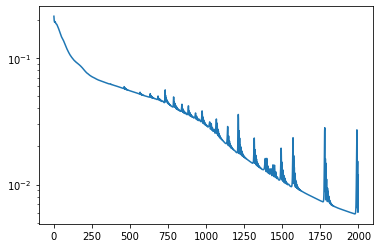

In [30]:
plt.semilogy(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

(TensorShape([20000, 1]), TensorShape([20000, 1]))

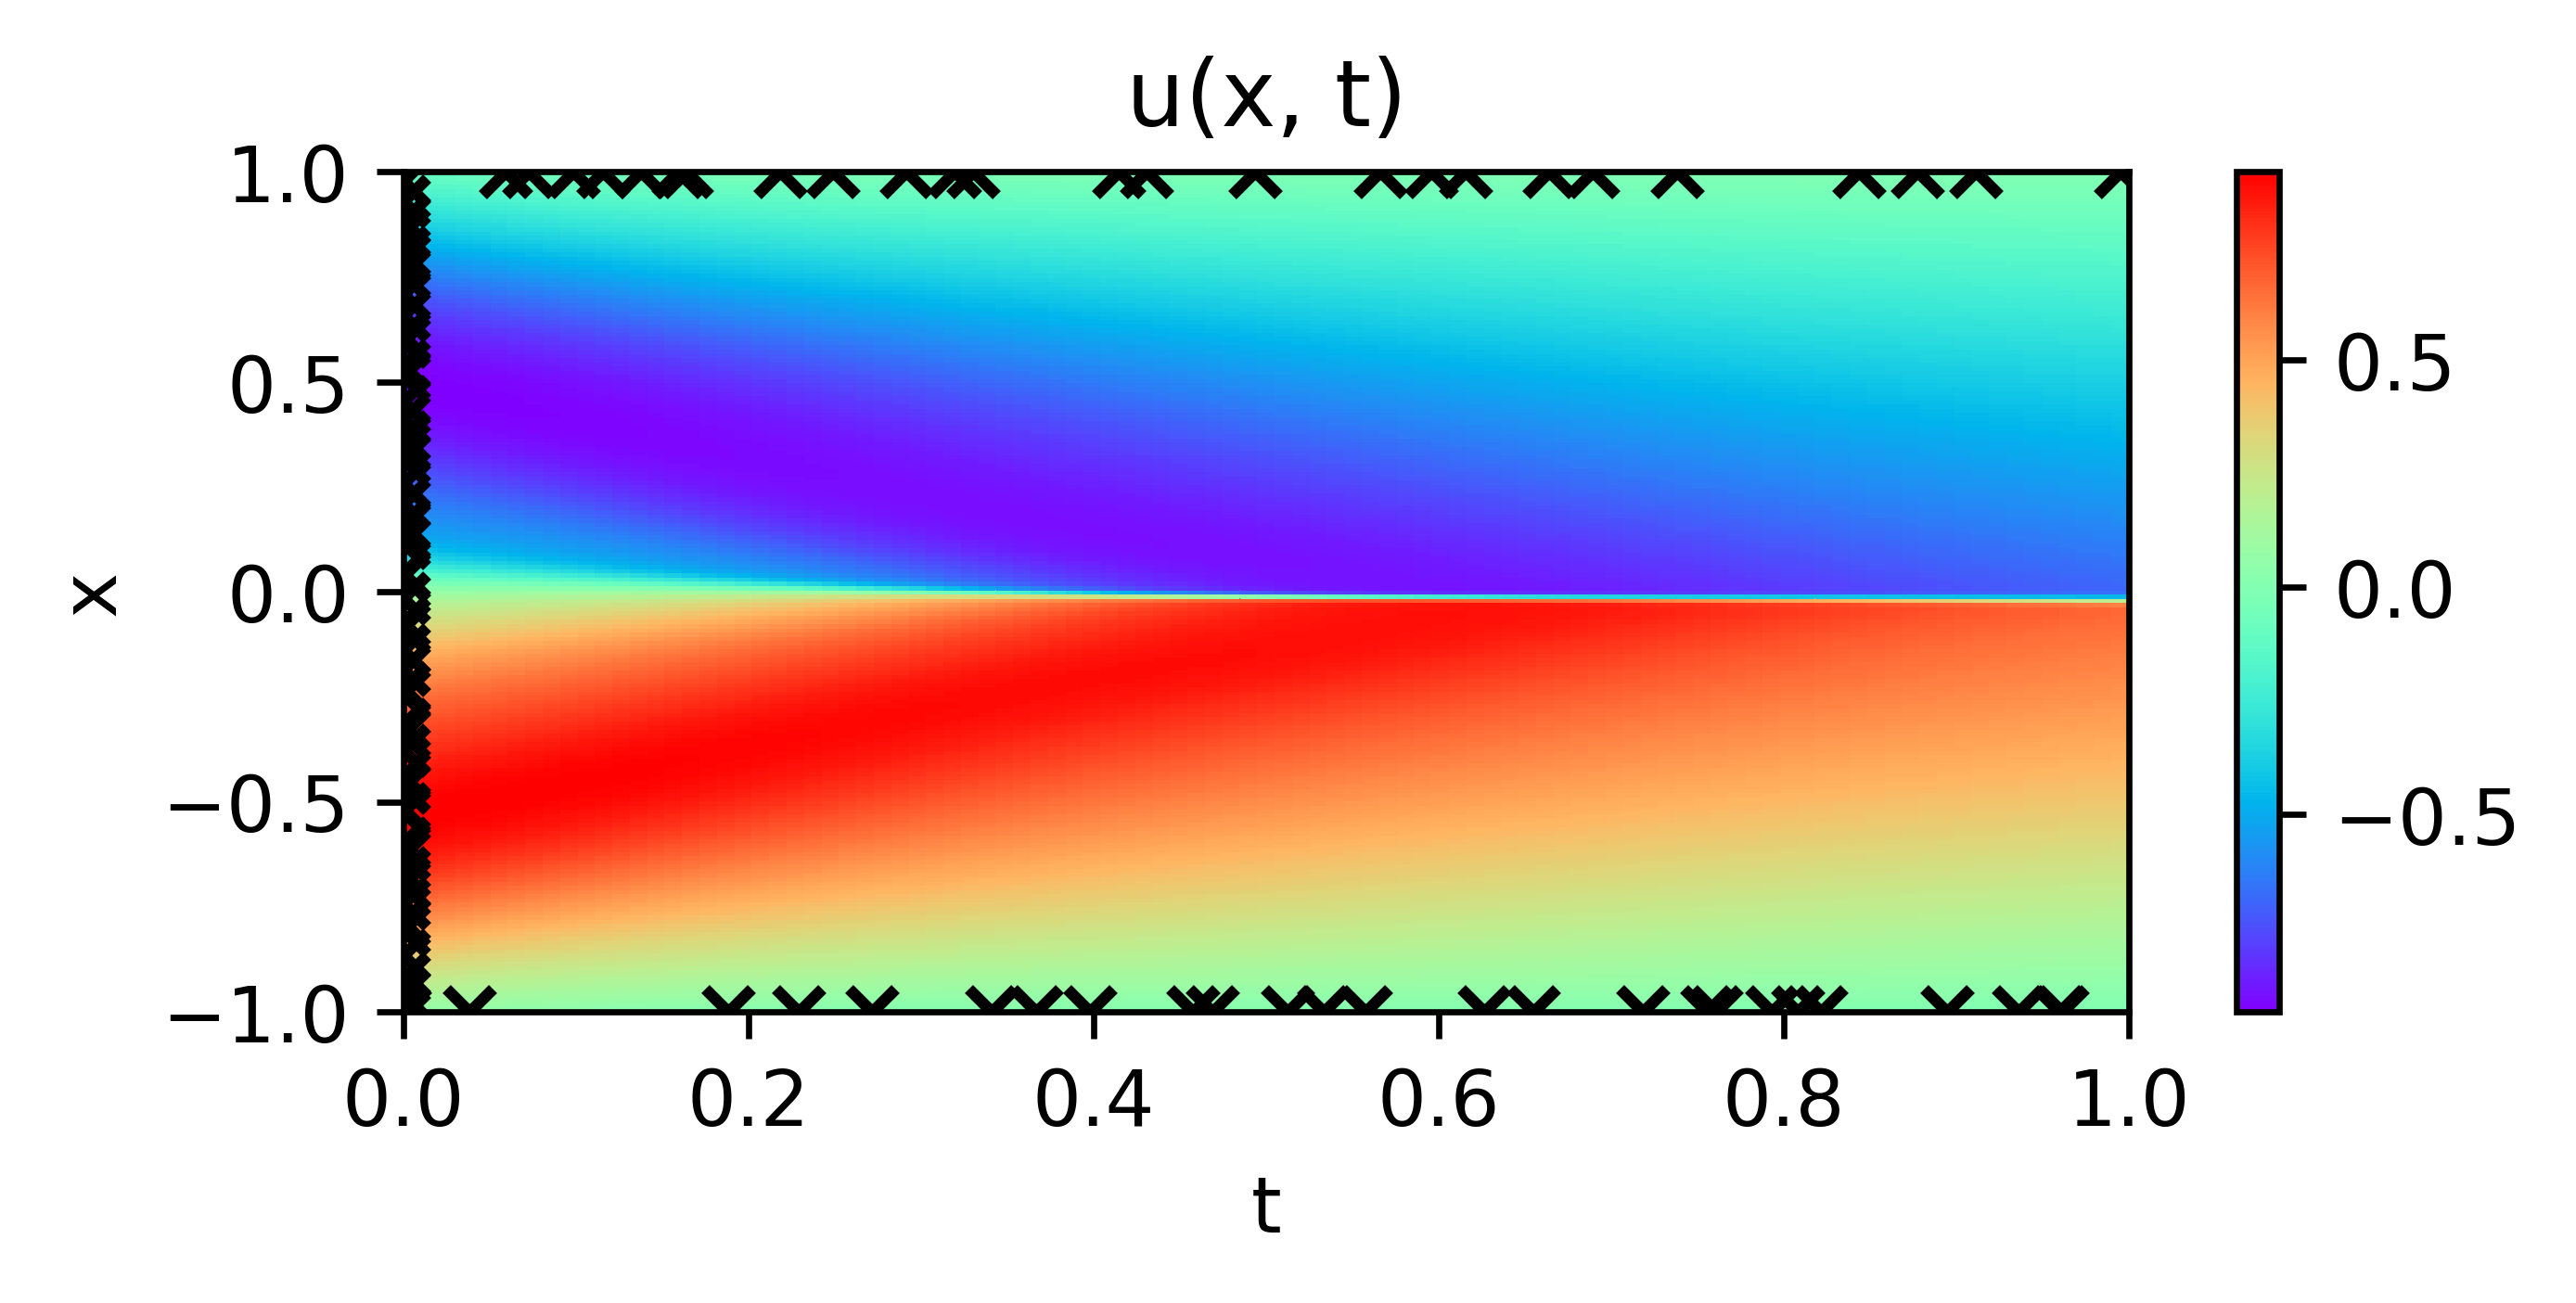

In [29]:
### plot
# another code is also available for ploting
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=600)
S = u(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

In [ ]:
# save and copy model to drive

model.save("burgers0.h5")
! cp burgers0.h5 drive/MyDrive